In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
%matplotlib inline

In [2]:
data = pd.read_csv("HK/top3.csv").drop('Unnamed: 0', axis = 1)

In [3]:
data = data.drop(['host_id', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365'], axis=1)

In [4]:
data.head(1)

,id,neighbourhood,latitude,longitude,room_type,price
0,69074,CENTRAL & WESTERN,22.28352,114.15018,Entire home/apt,1408


In [5]:
geo_data  = gpd.read_file("HK/Hong_Kong_18_Districts/Hong_Kong_18_Districts.shp").drop('TCNAME', axis = 1)
geo_data = geo_data.loc[geo_data['ENAME'].isin({'CENTRAL & WESTERN', 'WAN CHAI', 'YAU TSIM MONG'})]

In [6]:
grid = gpd.read_file("HK/Grid_3.shp")

In [7]:
data = gpd.GeoDataFrame(data,crs={'init' :'epsg:4326'}, geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [8]:
data.crs

{'init': 'epsg:4326'}

In [9]:
geo_data.crs

{'init': 'epsg:4326'}

In [10]:
# geo_data = geo_data.to_crs({'init': 'epsg:2326'}) 
# data = data.to_crs({'init': 'epsg:2326'}) 

In [11]:
grid = grid.to_crs({'init': 'epsg:4326'}) 

In [12]:
# view the spatial extent of both layers 
print(data.total_bounds)
print(grid.total_bounds)

[114.11971  22.25498 114.19532  22.32639]
[114.1133127   22.25062291 114.20961678  22.32524401]


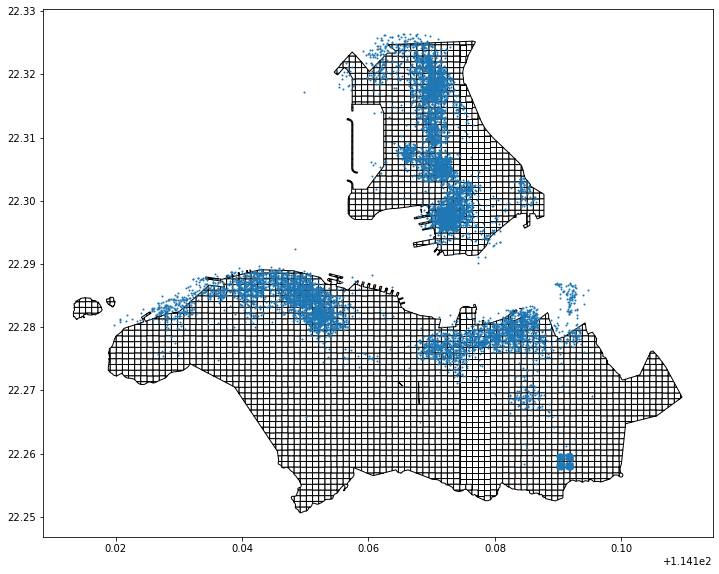

In [13]:
fig, ax = plt.subplots(figsize=(12,10))
grid.plot(color="white", edgecolor='black', ax= ax)
data.plot(markersize=1,ax=ax)

In [14]:
joined_data = gpd.sjoin(data, grid, op = 'within')

In [15]:
num_per_pix = joined_data.groupby(['index_right']).count()[['id']]
num_per_pix = num_per_pix.join(grid)
num_per_pix = num_per_pix.drop("Id", axis = 1).rename(columns={"id": "count"})
num_per_pix = gpd.GeoDataFrame(num_per_pix, geometry= 'geometry')
num_per_pix.head(2)

,count,geometry
index_right,,
9,5,"POLYGON ((114.16764 22.27591, 114.16861 22.275..."
15,7,"POLYGON ((114.16861 22.30751, 114.16763 22.307..."


In [16]:
en_pix = joined_data[data.room_type == 'Entire home/apt'].groupby(['index_right']).mean()[['price']]
en_pix = en_pix.join(grid)
en_pix = en_pix.drop("Id", axis = 1)
en_pix = gpd.GeoDataFrame(en_pix, geometry= 'geometry')
en_pix.head(2)

C:\Users\Martin\Anaconda3\lib\site-packages\geopandas\geodataframe.py:546: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  result = super(GeoDataFrame, self).__getitem__(key)


,price,geometry
index_right,,
9,798.000000,"POLYGON ((114.16764 22.27591, 114.16861 22.275..."
15,727.333333,"POLYGON ((114.16861 22.30751, 114.16763 22.307..."


In [17]:
pr_pix = joined_data[data.room_type == 'Private room'].groupby(['index_right']).mean()[['price']]
pr_pix = pr_pix.join(grid)
pr_pix = pr_pix.drop("Id", axis = 1)
pr_pix = gpd.GeoDataFrame(pr_pix, geometry= 'geometry')
pr_pix.head(2)

,price,geometry
index_right,,
9,450.0,"POLYGON ((114.16764 22.27591, 114.16861 22.275..."
15,549.5,"POLYGON ((114.16861 22.30751, 114.16763 22.307..."


In [18]:
sh_pix = joined_data[data.room_type == 'Shared room'].groupby(['index_right']).mean()[['price']]
sh_pix = sh_pix.join(grid)
sh_pix = sh_pix.drop("Id", axis = 1)
sh_pix = gpd.GeoDataFrame(sh_pix, geometry= 'geometry')
sh_pix.head(2)

,price,geometry
index_right,,
21,274.000000,"POLYGON ((114.18316 22.27771, 114.18219 22.277..."
53,234.666667,"POLYGON ((114.15308 22.28132, 114.15211 22.281..."


In [19]:
price_pix = joined_data.groupby(['index_right']).mean()[['price']]
price_pix = price_pix.join(grid)
price_pix = price_pix.drop("Id", axis = 1)
price_pix = gpd.GeoDataFrame(price_pix, geometry= 'geometry')
price_pix.head(2)

,price,geometry
index_right,,
9,658.800000,"POLYGON ((114.16764 22.27591, 114.16861 22.275..."
15,625.714286,"POLYGON ((114.16861 22.30751, 114.16763 22.307..."


# Spatial Weights and Spatial Lag

In [22]:
pip install esda

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install splot

  Using cached https://files.pythonhosted.org/packages/1d/72/9020b117e30df2b220b1442cc25f7e1438590aaac8ebc9e66f2c6d31e38b/quantecon-0.4.6-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [24]:
import pysal
from pysal.lib  import weights
from pysal.explore import  esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

In [25]:
w = weights.Queen.from_dataframe(num_per_pix)
w.transform = "R"

C:\Users\Martin\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 29 disconnected observations 
  Island ids: 9, 32, 42, 49, 68, 69, 78, 270, 290, 306, 321, 374, 403, 433, 448, 473, 479, 489, 522, 523, 592, 616, 671, 759, 766, 767, 773, 836, 866
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 270, ' is an island (no neighbors)')
('WARNING: ', 290, ' is an island (no neighbors)')
('WARNING: ', 306, ' is an island (no neighbors)')
('WARNING: ', 321, ' is an island (no neighbors)')
('WARNING: ', 374, ' is an island (no neighbors)')
('WARNING: ', 403, ' is an island (no neighbors)')
('WARNING: ', 433, ' is an island (no neighbors)')
('WARNING: ', 448, ' is an island (no neighbors)')
('WARNING: ', 473, ' is an island (no neighbors)')
('WARNING: ', 479, ' is an island (no neighbors)')
('WARNING: ', 489, ' is an island (no neighbors)')
('WARNING: ', 522, ' is an island (no neighbors)')
('WARNING: ', 523, ' is an island (no n

In [26]:
# num_per_pix["count_total"] = weights.lag_spatial(w, num_per_pix["count"])
# num_per_pix.head()

# Global Spatial Autocorrelation

In [27]:
y = num_per_pix["count"]
moran = Moran(y, w)
print('The Moran\'s I = ' + str(moran.I) + '\nThe significane = ' + str(moran.p_sim))

The Moran's I = 0.6912531885121372
The significane = 0.001


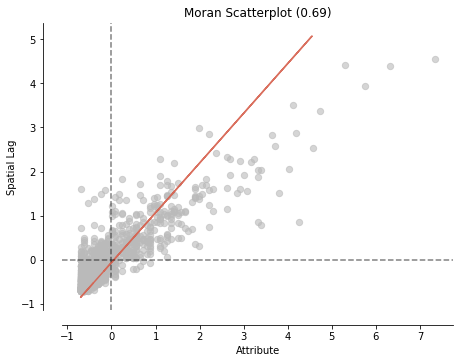

In [28]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
# plt.savefig("scatter-moran.png")
plt.show()

# Local Spatial Autocorrelation

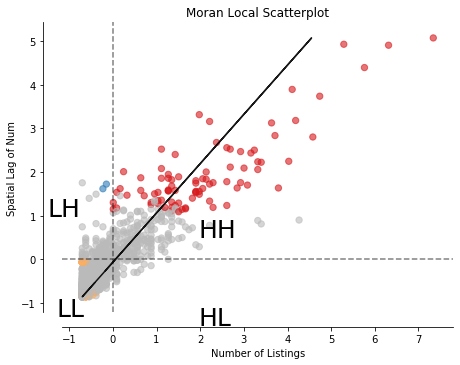

In [29]:
# calculate Moran Local 
m_local = Moran_Local(y, w)
# Plot
fig, ax = moran_scatterplot(m_local, p=0.01)
ax.set_xlabel('Number of Listings')
ax.set_ylabel('Spatial Lag of Num')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1, "LH", fontsize=25)
plt.text(-1.3, -1.3, "LL", fontsize=25)
plt.show()

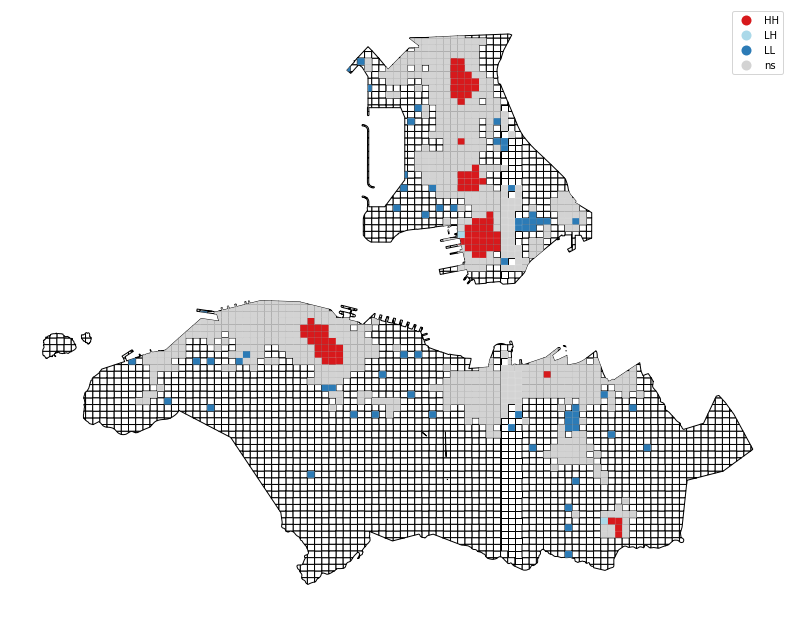

In [30]:
fig, ax = plt.subplots(figsize=(14,12))
grid.plot(color="white", edgecolor='black', ax= ax)
lisa_cluster(m_local, num_per_pix, p=0.01, figsize = (16,12),ax=ax)
plt.show()

# Calculating the Spatial Autocorrelation of Price

In [136]:
w = weights.Queen.from_dataframe(price_pix)
w.transform = "R"

C:\Users\Martin\Anaconda3\lib\site-packages\pysal\lib\weights\weights.py:168: UserWarning: There are 29 disconnected observations 
  Island ids: 9, 32, 42, 49, 68, 69, 78, 270, 290, 306, 321, 374, 403, 433, 448, 473, 479, 489, 522, 523, 592, 616, 671, 759, 766, 767, 773, 836, 866
  " Island ids: %s" % ', '.join(str(island) for island in self.islands))


('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 32, ' is an island (no neighbors)')
('WARNING: ', 42, ' is an island (no neighbors)')
('WARNING: ', 49, ' is an island (no neighbors)')
('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 69, ' is an island (no neighbors)')
('WARNING: ', 78, ' is an island (no neighbors)')
('WARNING: ', 270, ' is an island (no neighbors)')
('WARNING: ', 290, ' is an island (no neighbors)')
('WARNING: ', 306, ' is an island (no neighbors)')
('WARNING: ', 321, ' is an island (no neighbors)')
('WARNING: ', 374, ' is an island (no neighbors)')
('WARNING: ', 403, ' is an island (no neighbors)')
('WARNING: ', 433, ' is an island (no neighbors)')
('WARNING: ', 448, ' is an island (no neighbors)')
('WARNING: ', 473, ' is an island (no neighbors)')
('WARNING: ', 479, ' is an island (no neighbors)')
('WARNING: ', 489, ' is an island (no neighbors)')
('WARNING: ', 522, ' is an island (no neighbors)')
('WARNING: ', 523, ' is an island (no n

In [137]:
y = price_pix["price"]
moran = Moran(y, w)
print('The Moran\'s I = ' + str(moran.I) + '\nThe significane = ' + str(moran.p_sim))

The Moran's I = 0.008728819787857469
The significane = 0.077


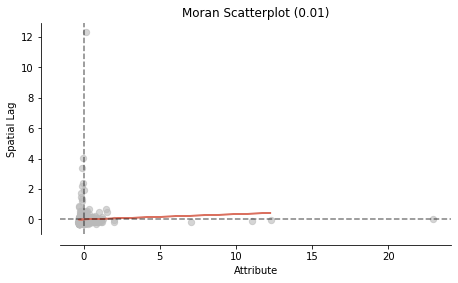

In [138]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
# plt.savefig("scatter-moran.png")
plt.show()

C:\Users\Martin\Anaconda3\lib\site-packages\esda\moran.py:886: RuntimeWarning: invalid value encountered in true_divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\Martin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Martin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Martin\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


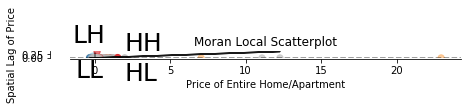

In [139]:
# calculate Moran Local 
m_local = Moran_Local(y, w)
# Plot
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel('Price of Entire Home/Apartment')
ax.set_ylabel('Spatial Lag of Price')
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-1.5, 1, "LH", fontsize=25)
plt.text(-1.3, -1.3, "LL", fontsize=25)
plt.show()

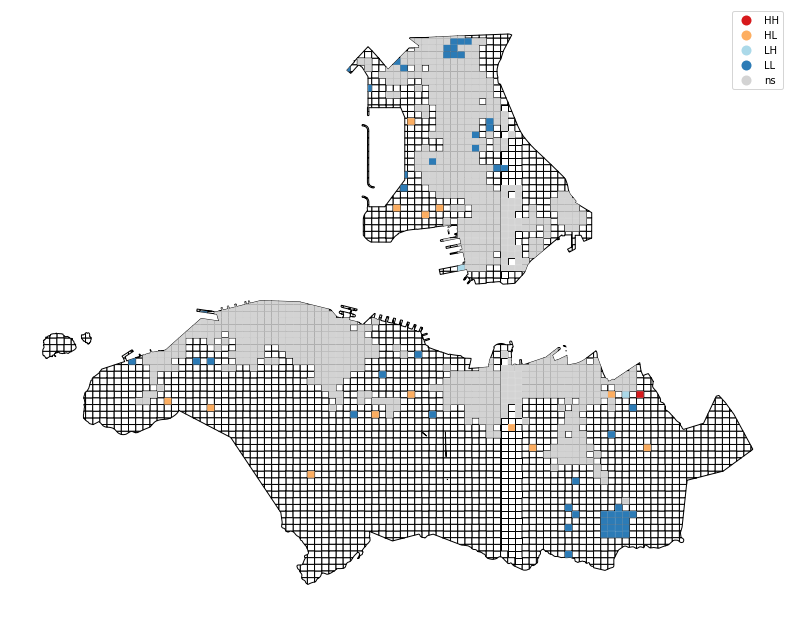

In [140]:
fig, ax = plt.subplots(figsize=(14,12))
grid.plot(color="white", edgecolor='black', ax= ax)
lisa_cluster(m_local, price_pix, p=0.01, figsize = (16,12),ax=ax)
plt.show()